<a href="https://colab.research.google.com/github/pushkar-khetrapal/realtime_panoptic/blob/master/RealTimePanoptic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
git clone https://github.com/pushkar-khetrapal/realtime_panoptic.git

Cloning into 'realtime_panoptic'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 90 (delta 34), reused 66 (delta 19), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [2]:
!wget https://wallup.net/wp-content/uploads/2016/01/256862-car-landscape-vehicle-road.jpg

--2020-08-17 16:37:49--  https://wallup.net/wp-content/uploads/2016/01/256862-car-landscape-vehicle-road.jpg
Resolving wallup.net (wallup.net)... 104.24.117.237, 104.24.116.237, 172.67.163.163, ...
Connecting to wallup.net (wallup.net)|104.24.117.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpg]
Saving to: ‘256862-car-landscape-vehicle-road.jpg’

256862-car-landscap     [   <=>              ]   1.60M  1.98MB/s    in 0.8s    

2020-08-17 16:37:50 (1.98 MB/s) - ‘256862-car-landscape-vehicle-road.jpg’ saved [1675401]



In [3]:
!wget https://tri-ml-public.s3.amazonaws.com/github/realtime_panoptic/models/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth

--2020-08-17 16:38:00--  https://tri-ml-public.s3.amazonaws.com/github/realtime_panoptic/models/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth
Resolving tri-ml-public.s3.amazonaws.com (tri-ml-public.s3.amazonaws.com)... 52.217.40.132
Connecting to tri-ml-public.s3.amazonaws.com (tri-ml-public.s3.amazonaws.com)|52.217.40.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122974869 (117M) [binary/octet-stream]
Saving to: ‘cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth’

cvpr_realtime_pano_ 100%[===================>] 117.28M  37.9MB/s    in 3.1s    

2020-08-17 16:38:04 (37.9 MB/s) - ‘cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth’ saved [122974869/122974869]



In [4]:
%%bash 
pip uninstall -y apex
git clone https://www.github.com/nvidia/apex
cd apex
python setup.py install



torch.__version__  = 1.6.0+cu101


running install
running bdist_egg
running egg_info
creating apex.egg-info
writing apex.egg-info/PKG-INFO
writing dependency_links to apex.egg-info/dependency_links.txt
writing top-level names to apex.egg-info/top_level.txt
writing manifest file 'apex.egg-info/SOURCES.txt'
writing manifest file 'apex.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/apex
copying apex/__init__.py -> build/lib/apex
creating build/lib/apex/normalization
copying apex/normalization/__init__.py -> build/lib/apex/normalization
copying apex/normalization/fused_layer_norm.py -> build/lib/apex/normalization
creating build/lib/apex/contrib
copying apex/contrib/__init__.py -> build/lib/apex/contrib
creating build/lib/apex/amp
copying apex/amp/__init__.py -> build/lib/apex/amp
copying apex/amp/opt.py -> build/lib/apex/amp
copying apex/amp/_amp_state.py -> build/li

Cloning into 'apex'...
setup.py:67: UserWarning: Option --pyprof not specified. Not installing PyProf dependencies!
  warnings.warn("Option --pyprof not specified. Not installing PyProf dependencies!")
zip_safe flag not set; analyzing archive contents...
apex.pyprof.nvtx.__pycache__.nvmarker.cpython-36: module references __file__
apex.pyprof.nvtx.__pycache__.nvmarker.cpython-36: module references __path__


In [5]:
!pip install yacs

In [6]:
!mv '/content/realtime_panoptic/realtime_panoptic' '/usr/local/lib/python3.6/dist-packages'

In [7]:
# This script provides a demo inference a model trained on Cityscapes dataset.
import warnings
import argparse
import torch
import numpy as np
from PIL import Image
from torchvision.models.detection.image_list import ImageList

from realtime_panoptic.models.rt_pano_net import RTPanoNet
from realtime_panoptic.config import cfg
import realtime_panoptic.data.panoptic_transform as P
from realtime_panoptic.utils.visualization import visualize_segmentation_image,visualize_detection_image

In [8]:
cityscapes_colormap = np.array([
 [128,  64, 128],
 [244,  35, 232],
 [ 70,  70,  70],
 [102, 102, 156],
 [190, 153, 153],
 [153, 153, 153],
 [250 ,170,  30],
 [220, 220,   0],
 [107, 142,  35],
 [152, 251, 152],
 [ 70, 130, 180],
 [220,  20,  60],
 [255,   0,   0],
 [  0,   0, 142],
 [  0,   0,  70],
 [  0,  60, 100],
 [  0,  80, 100],
 [  0,   0, 230],
 [119,  11,  32],
 [  0,   0,   0]])

cityscapes_instance_label_name = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
cfg.merge_from_file('/content/realtime_panoptic/configs/demo_config.yaml')

In [10]:
cfg.model.backbone

'R-50-FPN-RETINANET'

In [11]:
model = RTPanoNet(
    backbone=cfg.model.backbone, 
    num_classes=cfg.model.panoptic.num_classes,
    things_num_classes=cfg.model.panoptic.num_thing_classes,
    pre_nms_thresh=cfg.model.panoptic.pre_nms_thresh,
    pre_nms_top_n=cfg.model.panoptic.pre_nms_top_n,
    nms_thresh=cfg.model.panoptic.nms_thresh,
    fpn_post_nms_top_n=cfg.model.panoptic.fpn_post_nms_top_n,
    instance_id_range=cfg.model.panoptic.instance_id_range)
device = 'cuda'
model.to(device)

RTPanoNet(
  (backbone): ResNetWithModifiedFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bott

In [12]:
model.load_state_dict(torch.load('/content/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth'))

<All keys matched successfully>

In [13]:
# Prepare for model inference.
input_image = Image.open('/content/realtime_panoptic/media/figs/test.png')
data = {'image': input_image}
# data pre-processing
normalize_transform = P.Normalize(mean=cfg.input.pixel_mean, std=cfg.input.pixel_std, to_bgr255=cfg.input.to_bgr255)
transform = P.Compose([
    P.ToTensor(),
    normalize_transform,
])
data = transform(data)
print("Done with data preparation and model configuration.")
input_image_list = ImageList([data['image'].to(device)], image_sizes=[input_image.size[::-1]])
input = torch.stack(input_image_list.tensors)

Done with data preparation and model configuration.


In [14]:
!wget 'https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg'

--2020-08-17 16:38:33--  https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166289 (162K) [image/jpeg]
Saving to: ‘media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg’

media%2Fusers%2Fuse 100%[===================>] 162.39K  --.-KB/s    in 0.001s  

2020-08-17 16:38:33 (143 MB/s) - ‘media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg’ saved [166289/166289]



In [15]:
# Prepare for model inference.
model.eval()
input_image = Image.open('/content/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg')
data = {'image': input_image}
# data pre-processing
normalize_transform = P.Normalize(mean=cfg.input.pixel_mean, std=cfg.input.pixel_std, to_bgr255=cfg.input.to_bgr255)
transform = P.Compose([
    P.ToTensor(),
    normalize_transform,
])
data = transform(data)
print("Done with data preparation and model configuration.")
with torch.no_grad():
    input_image_list = ImageList([data['image'].to(device)], image_sizes=[input_image.size[::-1]])
    panoptic_result, _ = model.forward(input_image_list)
    print("Done with model inference.")
    print("Process and visualizing the outputs...")
    instance_detection = [o.to('cpu') for o in panoptic_result["instance_segmentation_result"]]
    semseg_logics = [o.to('cpu') for o in panoptic_result["semantic_segmentation_result"]]
    semseg_prob = [torch.argmax(semantic_logit , dim=0) for semantic_logit in  semseg_logics]

    seg_vis = visualize_segmentation_image(semseg_prob[0], input_image, cityscapes_colormap)
    Image.fromarray(seg_vis.astype('uint8')).save('semantic_segmentation_result.jpg')
    print("Saved semantic segmentation visualization in semantic_segmentation_result.jpg")
    det_vis = visualize_detection_image(instance_detection[0], input_image, cityscapes_instance_label_name)
    Image.fromarray(det_vis.astype('uint8')).save('instance_segmentation_result.jpg')
    print("Saved instance segmentation visualization in instance_segmentation_result.jpg")
    print("Demo finished.")

Done with data preparation and model configuration.
Done with model inference.
Process and visualizing the outputs...
Saved semantic segmentation visualization in semantic_segmentation_result.jpg
Saved instance segmentation visualization in instance_segmentation_result.jpg
Demo finished.


In [16]:
from realtime_panoptic.utils.panoptic_vis import panoptic_visualization
pan = panoptic_visualization(instance_detection[0], semseg_prob[0], input_image)

ValueError: ignored

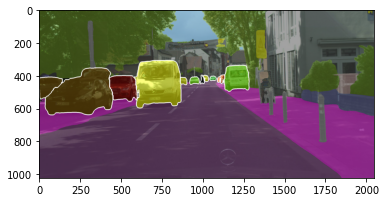

In [17]:
import matplotlib.pyplot as plt
plt.imshow(pan)

In [19]:
def panoptic(input_image):
  # Prepare for model inference.
  model.eval()
  data = {'image': input_image}
  # data pre-processing
  normalize_transform = P.Normalize(mean=cfg.input.pixel_mean, std=cfg.input.pixel_std, to_bgr255=cfg.input.to_bgr255)
  transform = P.Compose([
      P.ToTensor(),
      normalize_transform,

  ])
  data = transform(data)
    #print("Done with data preparation and model configuration.")
  with torch.no_grad():
      input_image_list = ImageList([data['image'].to(device)], image_sizes=[input_image.size[::-1]])
      panoptic_result, _ = model.forward(input_image_list)
      #print("Done with model inference.")
      #print("Process and visualizing the outputs...")
      instance_detection = [o.to('cpu') for o in panoptic_result["instance_segmentation_result"]]
      semseg_logics = [o.to('cpu') for o in panoptic_result["semantic_segmentation_result"]]
      semseg_prob = [torch.argmax(semantic_logit , dim=0) for semantic_logit in  semseg_logics]

      pan = panoptic_visualization(instance_detection[0], semseg_prob[0], input_image)
      return pan

In [41]:
from PIL import Image
import cv2
frame = cv2.imread('/content/realtime_panoptic/media/figs/test.png')
frame = Image.fromarray(np.uint8(frame)).convert('RGB')
z = panoptic(frame) 
Image.fromarray(z.astype('uint8')).save("/content/{}.jpg".format(1))

torch.Size([3, 1024, 2048])


/usr/local/lib/python3.6/dist-packages/realtime_panoptic/utils/panoptic_vis.py:139: RuntimeWarning: overflow encountered in exp
  z = 1/(1 + np.exp(-x))


In [21]:
!wget http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_MPEG2.mpg

--2020-08-17 16:43:51--  http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_MPEG2.mpg
Resolving s150102174.onlinehome.fr (s150102174.onlinehome.fr)... 217.160.0.161
Connecting to s150102174.onlinehome.fr (s150102174.onlinehome.fr)|217.160.0.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208220164 (199M) [video/mpeg]
Saving to: ‘Lara_UrbanSeq1_MPEG2.mpg’

Lara_UrbanSeq1_MPEG 100%[===================>] 198.57M  4.92MB/s    in 43s     

2020-08-17 16:44:34 (4.65 MB/s) - ‘Lara_UrbanSeq1_MPEG2.mpg’ saved [208220164/208220164]



In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import cv2 
from PIL import Image
import time
from realtime_panoptic.utils.panoptic_vis import panoptic_visualization

video = cv2.VideoCapture('/content/Lara_UrbanSeq1_MPEG2.mpg')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# We need to check if camera 
# is opened previously or not 
if (video.isOpened() == False): 
	print("Error reading video file") 

# We need to set resolutions. 
size = (width, height) 

count = 1
# Below VideoWriter object will create 
# a frame of above defined The output 
# is stored in 'filename.avi' file. 
start_time = time.time()
while(True): 
  ret, frame = video.read()
  print(count)
  if ret == True:

    frame = Image.fromarray(np.uint8(frame)).convert('RGB')
    z = panoptic(frame) 
    Image.fromarray(z.astype('uint8')).save("/content/drive/My Drive/RealTimePanoptic/{}.jpg".format(count))
      
    count = count + 1
    #cv2_imshow(detr(frame))
    # Break the loop 

  else:
    break

# When everything done, release 
# the video capture and video 
# write objects 
video.release() 

# Closes all the frames 
cv2.destroyAllWindows() 

print("The video was successfully saved") 
print("--- %s seconds ---" % (time.time() - start_time))
t = time.time() - start_time

In [21]:
1000/t

2.6920027664183475

In [29]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='/content/drive/My Drive/RealTimePanoptic'
fps=30

image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".jpg")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('/content/drive/My Drive/newmyVideo12.mp4')

[MoviePy] >>>> Building video /content/drive/My Drive/newmyVideo12.mp4
[MoviePy] Writing video /content/drive/My Drive/newmyVideo12.mp4


100%|██████████| 7270/7270 [04:00<00:00, 30.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/newmyVideo12.mp4 

